In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm

import os
import pickle

import SAM
import float_data as flt

from sklearn.decomposition import PCA

import importlib
importlib.reload(SAM)
importlib.reload(flt)

from dask import delayed

In [2]:
# Number of classes 
n_classes = 7
model_folder = 'model'
data_folder = 'data'

ids = ['r1i1p1f2', 'r3i1p1f2', 'r2i1p1f2', 'r8i1p1f2', 'r4i1p1f2', 'r9i1p1f2', 'r10i1p1f2']
#ids = ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2']
ids = ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r5i1p1f3', 'r6i1p1f3', 'r7i1p1f3', 'r8i1p1f2', 'r9i1p1f2', 'r10i1p1f2']
mask = np.load('data/mask.npy', allow_pickle=True)
probs = {}

In [3]:
path_ref = '{}/{}/{}'.format(model_folder, ids[0], n_classes)
with open('{}/avg.obj'.format(path_ref), 'rb') as file:
  ref_profiles = pickle.load(file)
  file.close()
    
inds = flt.temp_sort(None, ref_profiles, True)
ref_profiles = [ref_profiles[x] for x in inds]

for m_id in ids:
  
    
  print('Starting {}'.format(m_id))
  path_id = '{}/{}'.format(model_folder, m_id)
  path_n = '{}/{}/{}'.format(model_folder, m_id, n_classes)
  path_n_data = '{}/{}/{}'.format(data_folder, m_id, n_classes)
  file_path = '{}/sample_like.obj'.format(path_n_data)
  
  
  with open('{}/avg.obj'.format(path_n), 'rb') as file:
    avg_profiles = pickle.load(file)
    file.close()
    inds = flt.match_profiles(ref_profiles, avg_profiles)
  
  if os.path.isfile(file_path):
    with open(file_path, 'rb') as file:
      probs[m_id] = pickle.load(file)
      #probs[m_id] = probs[m_id].isel(k=inds)
      file.close()
    continue
    
    
  with open('{}/pca.obj'.format(path_id), 'rb') as file:
      pca = pickle.load(file)
      file.close()

  with open('{}/gmm.obj'.format(path_n), 'rb') as file:
      gmm = pickle.load(file)
      file.close()

  options = {'memberId' : m_id}
  
  data = flt.retrieve_profiles(timeRange = slice('1850-01', '1999-12'), mask=mask, options=options)
  data = data.chunk({'time': 30, 'n' : 4096})
  data_sampled = flt.normalise_data(data, ('n'))
  data_trans = flt.pca_transform(data_sampled, pca)
  #data_probs = (flt.gmm_score_samples(data_trans, gmm) * np.cos(np.pi * data_trans['lat']/180)).sum(('n'))
  data_probs = (flt.gmm_score_samples(data_trans, gmm)).mean(('n'))
  
  probs[m_id] = data_probs.compute()
  if not os.path.isdir(path_n_data):
      os.makedirs(path_n_data)
  with open(file_path, 'wb') as file:
      pickle.dump(probs[m_id], file)
      file.close()
print('Done!')

Starting r1i1p1f2
Starting r2i1p1f2
Starting r3i1p1f2
Starting r4i1p1f2
Starting r5i1p1f3
Starting r6i1p1f3
Starting r7i1p1f3
Starting r8i1p1f2
Starting r9i1p1f2
Starting r10i1p1f2
Done!


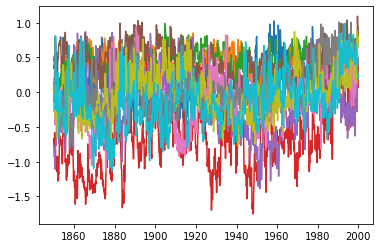

In [4]:
for m_id in ids:
  plt.plot(probs[m_id]['time'], probs[m_id])

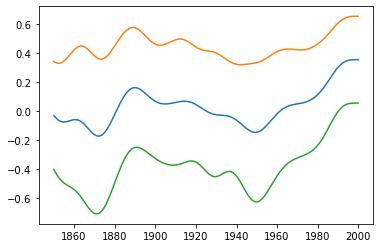

In [5]:
probs_filt = {}
for m_id in ids:
  probs_filt[m_id] = SAM.BW_filter(probs[m_id], 4, 1/24, 'time')

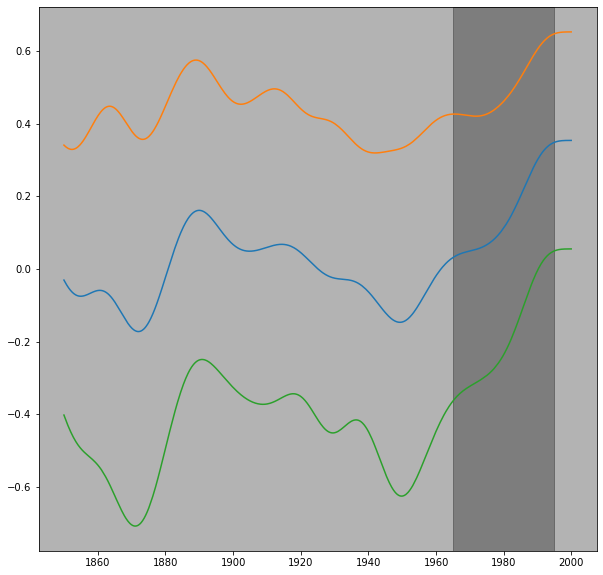

In [34]:
cmap = matplotlib.cm.get_cmap('YlOrRd')
fig, ax = plt.subplots()
ax.set_facecolor((0.7, 0.7, 0.7))
probs_all = xr.concat([x[1] for x in list(probs.items())], 'RunID')
mean_prob = SAM.BW_filter(probs_all.mean('RunID'), 4, 1/120, 'time')
std_prob = SAM.BW_filter(probs_all.std('RunID'), 4, 1/120, 'time')
plt.plot(probs[m_id]['time'], mean_prob)
plt.plot(probs[m_id]['time'], mean_prob + std_prob)
plt.plot(probs[m_id]['time'], mean_prob - std_prob)

ax.axvspan('1965-01', '1994-12', alpha=0.3, color='black')
fig.set_size_inches(10, 10)
  #plt.savefig('figures/like-{}'.format(m_id), dpi=300)

<xarray.DataArray 'thetao' (time: 1800)>
array([-0.05312888, -0.14136982, -0.07790079, ...,  0.19413515,
        0.21902945,  0.26347423])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 1999-12-01

In [21]:
arr = probs[m_id].values
arr_s = np.sum(arr, 1)
arr_s - np.mean(arr_s)

array([ 0.00000000e+00, -3.63797881e-12,  0.00000000e+00, ...,
       -5.45696821e-12, -5.45696821e-12,  0.00000000e+00])